In [2]:

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .otherwise(-1))  

C:\Users\seanz\AppData\Local\Temp\ipykernel_23372\19471023.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="play_type_index", y="count", data=play_type_counts, palette="viridis")


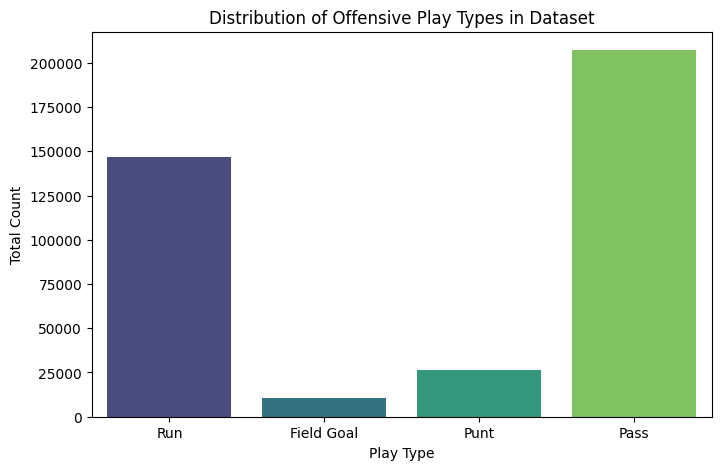

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each play type in df_indexed
play_type_counts = df_indexed.groupBy("play_type_index").count().toPandas()

# Mapping play type index to labels
play_type_labels = {0: "Pass", 1: "Run", 2: "Punt", 3: "Field Goal"}
play_type_counts["play_type_index"] = play_type_counts["play_type_index"].map(play_type_labels)

# Plot the play type distribution
plt.figure(figsize=(8, 5))
sns.barplot(x="play_type_index", y="count", data=play_type_counts, palette="viridis")

plt.title("Distribution of Offensive Play Types in Dataset")
plt.xlabel("Play Type")
plt.ylabel("Total Count")

# Show plot
plt.xticks(rotation=0)
plt.show()

In [3]:
df.count()

390965

In [10]:

from sklearn.metrics import log_loss
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from xgboost import XGBClassifier
import numpy as np
import joblib
import os


spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .otherwise(-1))  

feature_columns = [
    # Field Position & Time
    'yardline_100', 'game_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo', 
    'score_differential_post', 'posteam_score_post',

    # Game Context & Situational Awareness
    'quarter_seconds_remaining', 'half_seconds_remaining', 'drive', 'score_differential',

    # Play History (Momentum)
    'play_success', 'cumulative_rush_attempts', 'cumulative_pass_attempts', 
    'cumulative_rush_successes', 'cumulative_pass_successes', 'rush_success_rate', 
    'pass_success_rate', 'posteam_leading', 'posteam_trailing',

    # Critical 3rd/4th Down Context
    'third_down_converted', 'third_down_failed', 'fourth_down_converted', 'fourth_down_failed',

    # Play Consequences
    'incomplete_pass', 'sack', 'touchback', 'interception',

    # Special Teams Indicators
    'punt_blocked', 'punt_inside_twenty', 'punt_in_endzone', 'punt_out_of_bounds'
]


assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_vector = assembler.transform(df_indexed)

games = df_vector.select("game_id").distinct().collect()  
train_games = games[:int(0.8 * len(games))] 
test_games = games[int(0.8 * len(games)):]

train_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in train_games]))
test_df = df_vector.filter(col("game_id").isin([game["game_id"] for game in test_games]))

# === 1. CONVERT DATA TO PANDAS === #
train_pandas = train_df.toPandas()
test_pandas = test_df.toPandas()

# Convert feature vectors back to NumPy arrays
X_train = np.array(train_pandas["features"].tolist())
y_train = np.array(train_pandas["play_type_index"].tolist())

X_test = np.array(test_pandas["features"].tolist())
y_test = np.array(test_pandas["play_type_index"].tolist())

# Define paths
# Define paths
model_path = "xgboost_football_model.pkl"
loss_path = "xgboost_loss_results.pkl"

# Check if model exists
if os.path.exists(model_path):
    print("✅ Loading pre-trained XGBoost model...")
    xgb = joblib.load(model_path)
else:
    print("🚀 Training new XGBoost model...")

    # Train XGBoost model
    xgb = XGBClassifier(
        max_depth=9,  
        learning_rate=0.05,  
        n_estimators=200,  
        scale_pos_weight=1,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        random_state=42
    )
    
    # Train model
    xgb.fit(X_train, y_train)

    # Save model
    joblib.dump(xgb, model_path)
    print(f"✅ Model saved at: {model_path}")

    # **MANUAL DEBUGGING TO SEE WHAT'S HAPPENING**
    try:
        train_preds = xgb.predict_proba(X_train)
        test_preds = xgb.predict_proba(X_test)

        print(f"🔍 Train Predictions Shape: {train_preds.shape}")
        print(f"🔍 Test Predictions Shape: {test_preds.shape}")

        train_loss = log_loss(y_train, train_preds)
        test_loss = log_loss(y_test, test_preds)

        print(f"📉 Train Loss: {train_loss:.4f}")
        print(f"📉 Test Loss: {test_loss:.4f}")

        # Save the losses
        loss_results = {"train_loss": train_loss, "test_loss": test_loss}
        joblib.dump(loss_results, loss_path)
        print(f"✅ Loss results saved at: {loss_path}")

    except Exception as e:
        print(f"❌ ERROR: {e}")

# **FORCE CHECK IF LOSS FILE EXISTS**
if os.path.exists(loss_path):
    print("🎉 Loss file successfully saved!")
else:
    print("❌ LOSS FILE STILL MISSING! WTF is going on?")

🚀 Training new XGBoost model...


c:\Users\seanz\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Model saved at: xgboost_football_model.pkl
🔍 Train Predictions Shape: (313178, 4)
🔍 Test Predictions Shape: (77787, 4)
📉 Train Loss: 0.2849
📉 Test Loss: 0.3072
✅ Loss results saved at: xgboost_loss_results.pkl
🎉 Loss file successfully saved!


In [ ]:

from sklearn.metrics import log_loss
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from xgboost import XGBClassifier
import numpy as np
import joblib
import os

spark = SparkSession.builder.config("spark.driver.host", "localhost").config("spark.python.worker.reuse", "false").getOrCreate()
file_path = 'file:///C:/Users/seanz/VSCode_WS/BigData/NFL_PBP_V1.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

df = df.withColumn(
    'play_success', 
    F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1
    ).otherwise(0)
)

window_spec = Window.partitionBy('game_id', 'posteam').orderBy('play_id')
df = df.withColumn(
    'cumulative_rush_attempts', 
    F.sum(F.when((F.col('play_type') == 'run') & (F.col('rush_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_attempts', 
    F.sum(F.when((F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1), 1).otherwise(0)).over(window_spec)
)

df = df.withColumn(
    'cumulative_rush_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'run') & (F.col('rush_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'cumulative_pass_successes', 
    F.sum(F.when(
        (F.col('play_type') == 'pass') & (F.col('pass_attempt') == 1) & (F.col('yards_gained') >= 4), 1).otherwise(0)
    ).over(window_spec)
)

df = df.withColumn(
    'rush_success_rate', 
    F.when(F.col('cumulative_rush_attempts') > 0, F.col('cumulative_rush_successes') / F.col('cumulative_rush_attempts')).otherwise(0)
)

df = df.withColumn(
    'pass_success_rate', 
    F.when(F.col('cumulative_pass_attempts') > 0, F.col('cumulative_pass_successes') / F.col('cumulative_pass_attempts')).otherwise(0)
)

df = df.withColumn('posteam_leading', F.col('score_differential_post') > 0)
df = df.withColumn('posteam_trailing', F.col('score_differential_post') < 0)
df = df.withColumn('yards_gained', F.col('yards_gained').cast('float'))
df = df.withColumn('shotgun', F.col('shotgun').cast('float'))
df = df.withColumn('no_huddle', F.col('no_huddle').cast('float'))
df = df.withColumn('timeout', F.col('timeout').cast('float'))
df = df.withColumn('posteam_timeouts_remaining', F.col('posteam_timeouts_remaining').cast('float'))
df = df.withColumn('defteam_timeouts_remaining', F.col('defteam_timeouts_remaining').cast('float'))
offensive_playtypes = ['field_goal', 'run', 'punt', 'pass']
df = df.filter(df.play_type.isin(offensive_playtypes))

df_indexed = df.withColumn('play_type_index', 
                           F.when(F.col('play_type') == 'pass', 0)
                            .when(F.col('play_type') == 'run', 1)
                            .when(F.col('play_type') == 'punt', 2)
                            .when(F.col('play_type') == 'field_goal', 3)
                            .otherwise(-1))  

df_p = df_indexed.toPandas()


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,play_success,cumulative_rush_attempts,cumulative_pass_attempts,cumulative_rush_successes,cumulative_pass_successes,rush_success_rate,pass_success_rate,posteam_leading,posteam_trailing,play_type_index
0,375,2009091310,NYG,WAS,WAS,away,NYG,WAS,71.0,2009-09-13,...,1,1,0,1,0,1.000000,0.000000,False,True,1
1,401,2009091310,NYG,WAS,WAS,away,NYG,NYG,37.0,2009-09-13,...,0,1,1,1,0,1.000000,0.000000,False,True,0
2,420,2009091310,NYG,WAS,WAS,away,NYG,NYG,48.0,2009-09-13,...,0,2,1,1,0,0.500000,0.000000,False,True,1
3,441,2009091310,NYG,WAS,WAS,away,NYG,NYG,45.0,2009-09-13,...,1,2,2,1,1,0.500000,0.500000,False,True,0
4,469,2009091310,NYG,WAS,WAS,away,NYG,NYG,38.0,2009-09-13,...,0,2,2,1,1,0.500000,0.500000,False,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2140,2009091311,SEA,STL,SEA,home,STL,STL,12.0,2009-09-13,...,1,15,24,6,14,0.400000,0.583333,True,False,0
96,2266,2009091311,SEA,STL,SEA,home,STL,SEA,74.0,2009-09-13,...,1,16,24,7,14,0.437500,0.583333,True,False,1
97,2287,2009091311,SEA,STL,SEA,home,STL,SEA,67.0,2009-09-13,...,1,16,25,7,15,0.437500,0.600000,True,False,0
98,2311,2009091311,SEA,STL,SEA,home,STL,SEA,62.0,2009-09-13,...,0,16,26,7,15,0.437500,0.576923,True,False,0


In [9]:
print(df_p.head(100).to_string())

    play_id     game_id home_team away_team posteam posteam_type defteam side_of_field  yardline_100   game_date  quarter_seconds_remaining  half_seconds_remaining  game_seconds_remaining game_half  quarter_end  drive  sp  qtr  down  goal_to_go                time   yrdln  ydstogo  ydsnet                                                                                                                                                                                                                                                                                                                                                            desc   play_type  yards_gained  shotgun  no_huddle  qb_dropback  qb_kneel  qb_spike  qb_scramble pass_length pass_location air_yards yards_after_catch run_location run_gap field_goal_result kick_distance extra_point_result two_point_conv_result home_timeouts_remaining away_timeouts_remaining  timeout timeout_team td_team  posteam_timeouts_remaining  defteam_tim